<a href="https://colab.research.google.com/github/MichaelDeng03/GenAI_Agents/blob/main/all_agents_tutorials/art_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Art Agent
This tutorial will walk through the creation of an AI Agent that helps you explore and learn art!

### Overview
For knowledge retrieval, this tutorial uses [LightRAG](https://github.com/HKUDS/LightRAG) which is knowledge graph based RAG implementation. Compared to GraphRAG, LightRAG is more accurate for single topic datasets, and uses 1,000x less tokens for retrieval. Furthermore, documents can be added to LightRAG incrementally without rebuilding the knowledge graph. See the full results in the [paper](https://arxiv.org/abs/2410.05779).

For the agent itself, we use LangGraph.

### Outline
0. [Setup](#setup)
1. [Data Preparation + RAG](#data-preparation--rag)
2. [Agent Creation](#agent-creation)
3. [Final App](#final-app)

### Setup

# ENV

This tutorial uses openai embedding models. While there are alternatives, we recommend using the openai models for the best results.

```
export OPENAI_API_KEY=sk....
```

In [ ]:
!uv pip install lightrag-hku aioboto3 numpy ollama openai tenacity aioboto3 transformers torch tiktoken nano_vectordb neo4j oracledb textract setuptools pyvis sqlalchemy langchain_community langchain_openai sqlmodel ipywidgets==7.7.1 asyncio markdown

Using Python 3.12.7 environment at /home/madeng/AbstractOperator/GenAI_Agents/.venv
Resolved 192 packages in 99ms                                        
Uninstalled 1 package in 0.73ms
Installed 1 package in 1ms                                  
 - six==1.16.0
 + six==1.12.0


In [79]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, TwoByTwoLayout, Text, AppLayout, GridspecLayout
import ipywidgets as widgets
from IPython.display import display, Markdown
from IPython.display import Markdown

import os
import operator
from datetime import datetime
from typing import Any, Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from IPython.display import Image, display, Markdown

from langgraph.graph import Graph, END
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image as IPImage

from lightrag.llm import gpt_4o_mini_complete
from lightrag import LightRAG, QueryParam
from dotenv import load_dotenv

import markdown

In [ ]:
def get_artwork_image_url(url: str):
    """
    Gets an artwork image from its URL.
    """
    import requests
    from bs4 import BeautifulSoup as bs

    url = f"https://wikiart.org{url}"
    response = requests.get(url)
    soup = bs(response.text, "html.parser")
    img = soup.find("img", {"itemprop": "image"})
    # return Image(url=img.get("src"))
    return img.get("src")

In [81]:
def create_image_widget(artwork_url: str):
    return widgets.HTML(value=f'<img src="{get_artwork_image_url(artwork_url)}">')


def create_description_box(description: str):
    return widgets.HTML(markdown.markdown(description))
    # return widgets.HTML(value=f'<h1>{description}</h1>')


exit_loop = False

prompt_input = widgets.Text(value='helloworld')


def callback(widget):
    # Start workflow loop
    pass


prompt_input.on_submit(callback)

grid_layout = GridspecLayout(20, 1)
grid_layout[0, 0] = create_description_box("foo 1637")
grid_layout[1:12, 0] = create_image_widget('/en/pieter-codde/the-meagre-company-1637')
grid_layout[13, 0] = create_description_box("this is a llm response")
grid_layout[14, 0] = prompt_input

grid_layout

GridspecLayout(children=(HTML(value='<p>foo 1637</p>', layout=Layout(grid_area='widget001')), HTML(value='<img…

### Data Preparation + RAG

#### Data Preparation

We scraped data from [wikiart](https://wikiart.org/) using a combination of requests and beautiful soup. 

We provide a preprocessed, limited dataset of this data for the tutorial found in `data/idfk.json`. 

Preprocessed data for each artwork looks like:

```plaintext
Artwork Name: {artwork_name}
Artwork Genre: {genre_list}
Artwork Media: {media_list}
Wikiart URL: https://www.wikiart.org{wikiart_slug}

Wikipedia Article:
{wiki_article}
```


#### LightRAG


### Agent Creation

In [89]:
from lightrag.llm import gpt_4o_mini_complete
from lightrag import LightRAG, QueryParam
from dotenv import load_dotenv

load_dotenv()

WORKING_DIR = "./data"
rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=gpt_4o_mini_complete,
)

import nest_asyncio

nest_asyncio.apply()

INFO:lightrag:Logger initialized for working directory: ./data
INFO:lightrag:Load KV llm_response_cache with 296 data
INFO:lightrag:Load KV full_docs with 78 data
INFO:lightrag:Load KV text_chunks with 78 data
INFO:lightrag:Loaded graph from ./data/graph_chunk_entity_relation.graphml with 730 nodes, 598 edges
INFO:nano-vectordb:Load (724, 1536) data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_entities.json'} 724 data
INFO:nano-vectordb:Load (598, 1536) data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_relationships.json'} 598 data
INFO:nano-vectordb:Load (179, 1536) data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_chunks.json'} 179 data


In [104]:
def describe_painting(painting: str):
    metadata = rag.query(
        f"""What is the genre, media, and style of the following painting: {painting}. 
    Return the description in the following format:
    artwork name: <artwork name>
    artist: <artist>
    genre: <genre>
    media: <media>
    style: <style>
    
    Return this information and nothing else.
    """,
        param=QueryParam(mode="hybrid"),
    )

    dense_description = str(rag.query(f"describe {painting}", param=QueryParam(mode="hybrid")))

    return {"metadata": metadata, "dense_description": dense_description}

In [105]:
description = describe_painting("Down on his luck")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 141 relations, 12 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 45 entites, 60 relations, 10 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 1 entites, 0 relations, 1 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 19 entites, 12 relations, 7 text units


In [106]:
print(f'metadata: {description["metadata"]}')
print(f'dense_description: {description["dense_description"]}')

metadata: ```markdown
artwork name: Down on His Luck  
artist: Frederick McCubbin  
genre: genre painting  
media: canvas, oil  
style: Impressionism  
```
dense_description: ### Overview of "Down on His Luck"

"Down on His Luck" is a poignant painting created by the Australian artist Frederick McCubbin in 1889. As a genre painting, it captures a moment of deep reflection and despondency, characteristic of McCubbin’s exploration of the human condition through his art. The painting depicts a disheartened swagman—an itinerant worker—sitting by a campfire, brooding over his misfortune amidst a natural Australian landscape.

### Artistic Elements and Themes

The central figure is rendered in a manner that suggests a blend of realism with an emotional depth that communicates the hardships faced by the swagman. His expression reflects a nonchalant yet cynical demeanor, embodying a mixture of resignation and survival instinct. The subdued tones of the surrounding bush contribute to the somber

In [112]:
def get_next_painting(prev_painting: str, next_painting: str):
    prompt = f"""You are an art tour guide. 
    You just discussed this painting:
    {prev_painting} 
    
    The user has requested the following for their next painting. Choose a related painting.
    {next_painting}
    
    Return the name of the painting and nothing else.
    """

    return rag.query(prompt, param=QueryParam(mode="hybrid"))


next_painting = get_next_painting(
    description['metadata'], "I want to see paintings by a different artist of the same genre."
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 160 relations, 10 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 43 entites, 60 relations, 6 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [113]:
print(next_painting)

The Pink Dress


In [134]:
def get_artwork_url_from_name(artwork_name: str):
    prompt = f"""
    What is the Wikiart URL for this painting: {artwork_name}
    
    Return only the wikiart url in plain text.
    """
    return rag.query(prompt, param=QueryParam(mode="hybrid"))

In [135]:
next_painting_url = get_artwork_url_from_name(next_painting)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 86 relations, 7 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 46 entites, 60 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [136]:
print(next_painting_url)

https://www.wikiart.org/en/frederic-bazille/the-pink-dress


In [ ]:
current_painting = "https://www.wikiart.org/en/pierre-auguste-renoir/ball-at-the-moulin-de-la-galette-1876"

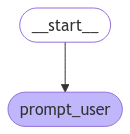

In [31]:

workflow = Graph()
workflow.add_node('prompt_user', prompt_user)
workflow.add_node(
# workflow.add_edge('prompt_user')
workflow.set_entry_point('prompt_user')
app = workflow.compile()
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
async def run_workflow(query: str)

### Final App

In [ ]:
# User Loop
current_image = "https://www.wikiart.org/en/pierre-auguste-renoir/ball-at-the-moulin-de-la-galette-1876"
description = describe_painting(current_image)
app_running = True
while app_running:
    while current_painting:
        

    